In [13]:
# import libraries
import math
import scipy
import numpy as np
import matplotlib as mpl
import scipy.integrate as integrate
import matplotlib.colors as colors
import matplotlib.cm as cmx
import pandas as pd
import seaborn as sns
from scipy.stats import skewnorm
from scipy.optimize import curve_fit
from scipy.integrate import odeint
%matplotlib inline
import matplotlib.pyplot as plt

import re
import h5py
from scipy.interpolate import interp1d
import glob

from scipy import signal
from scipy import optimize, signal
from symfit import Parameter, Variable
from symfit import Fit
#from symfit import NumericalLeastSquares
from symfit import parameters, variables, D, ODEModel, exp
from symfit.core.minimizers import BasinHopping
#from symfit.core.objectives import LogLikelihood
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


# constants in SI
m_e = 9.10938291E-31 # mass of electron
e_charge = 1.60217657E-19 # charge of electron
eV = 1.60217657E-19 # 1 electron volt in joules
ε_0 = 8.85418782E-12 # permittivity of free space
h = 6.62606957E-34 # planck number
h_ev = 4.135667662E-15 #Plank number eV.s
hbar = 1.054571800E-34 # reduced planck constant
Rydberg = 2.1787E-18 # Rydberg energy (in joules)
avogadro = 6.02214179E23
c = 299792458 # m/s
sigma_ev = 3.54E11 #ev/m^2/s/K^4
sigma = 5.670367E-8 #J/m^2/s/K^4
# units in SI
Å = 1E-10 # m to angstrom
k_b = 1.38064852E-23 #J/K
k_ev = 8.6173303E-5 #ev/K

def peak_max(x_array,y_array, valuerange_low, valuerange_high):
    idx_lo = (np.abs(x_array - valuerange_low)).argmin()
    idx_hi = (np.abs(x_array - valuerange_high)).argmin()
    max_peak = max(y_array[idx_lo:idx_hi])
    return max_peak
def find_nearest_idx(array, value):
    #array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
def find_zero_idx_range(xarray,y1, y2,xmin,xmax):
    i1 = find_nearest_idx(xarray,xmin)
    i2 = find_nearest_idx(xarray,xmax)
    idx_zero = find_nearest_idx((y1[i1:i2]-y2[i1:i2]),0)
    return idx_zero
def background_f(x_array,y_array, valuerange_low, valuerange_high):
    idx_lo = (np.abs(x_array - valuerange_low)).argmin()
    idx_hi = (np.abs(x_array - valuerange_high)).argmin()
    background_val = np.mean(y_array[idx_lo:idx_hi])
    return background_val

In [14]:
kinetic_data = np.genfromtxt("charge_exciton_kinetics_GA_700nm_just_charge_mask.csv",delimiter=',',skip_header = 1)
tt_data_1 = kinetic_data[:,0]
tt_data_2 = (tt_data_1*np.ones((4,tt_data_1.size))).T

exciton_data = kinetic_data[:,1::2]
charge_data = kinetic_data[:,2::2]

##sort time zeros
tt_data = tt_data_2
tt_data[:,0] = tt_data_2[:,0]-.2
tt_data[:,1] = tt_data_2[:,1]-.12
tt_data[:,2] = tt_data_2[:,2]+.05
tt_data[:,3] = tt_data_2[:,3]#+.1
#change units to mm^3 ps-1 rather than cm^3 s-1
t_0 = 2.5 #set time to model from

norm_mult = 1.02

t_0_idx = find_nearest_idx(tt_data[:,0],t_0)
exciton_1 = norm_mult*exciton_data[t_0_idx:,0]/max(exciton_data[t_0_idx:,0])
exciton_2 = norm_mult*exciton_data[t_0_idx:,1]/max(exciton_data[t_0_idx:,1])
exciton_3 = norm_mult*exciton_data[t_0_idx:,2]/max(exciton_data[t_0_idx:,2])
t_data1 = (tt_data[t_0_idx:,0]-t_0)*1e-12
charge_1 = norm_mult*charge_data[t_0_idx:,0]/max(charge_data[t_0_idx:,0])
charge_2 = norm_mult*charge_data[t_0_idx:,1]/max(charge_data[t_0_idx:,1])
charge_3 = norm_mult*charge_data[t_0_idx:,2]/max(charge_data[t_0_idx:,2])


t_data1 = (tt_data[t_0_idx:,0]-t_0)

In [31]:
a_s_non =Parameter('a_s_non', value = (1/(395)),min = 0,absolute_sigma = False,fixed = False)#1/(280)
a_s_split = Parameter('a_s_split', value =(1/(1200)),min = 0,absolute_sigma = False,fixed = True)#1/(120e-12)
a_s_rad = Parameter('a_s_rad',value =1/3400,min = 0,fixed = True)#1e6,min = 0,fixed = True)
b_s = Parameter('b_s', value = 0.2e-8*1e-12*1e3,min = 0,absolute_sigma = False,fixed = True)##2.2e-11*1e12
b_s_fc = Parameter('b_s_fc', value = 1e-8*1e-12*1e3,min = 0,absolute_sigma = False,fixed = True)#.495e-11,min = 0,fixed = False)

a_ct_split = Parameter('a_ct_split', value =(1/(1200)),min = 0,absolute_sigma = False,fixed = True)#1/(120e-12)
a_ct_join = Parameter('a_ct_join', value =(1/(1200)),min = 0,absolute_sigma = False,fixed = True)#1/(120e-12)
a_ct_non= Parameter('a_ct_non', value =(1/(1200)),min = 0,absolute_sigma = False,fixed = True)#1/(120e-12)
b_ct =Parameter('b_ct', value = 0.2e-8*1e-12*1e3,min = 0,absolute_sigma = False,fixed = True)##2.2e-11*1e12
a_ct_isc =Parameter('a_ct_isc', value = 0.2e-8*1e-12*1e3,min = 0,absolute_sigma = False,fixed = True)##2.2e-11*1e12

a_fc_non = Parameter('a_fc_non',value =1/(1030),min = 0,absolute_sigma = False, fixed =True)
b_fuse = Parameter('b_fuse', value = 0.5e-8*1e-12*1e3,min = 0,absolute_sigma = False, fixed = True)#1.45e-11*1e12

excitons1,ct_s1,ct_t1,fc1,t,excitons2,ct_s2,ct_t2,fc2,excitons3,ct_s3,ct_t3,fc3 = variables('excitons1,ct_s1,ct_t1,fc1,t,excitons2,ct_s2,ct_t2,fc2,excitons3,ct_s3,ct_t3,fc3')

wavelength = 700e-9
thickness = 130e-9
k = 1.3 #from kerremans, Armin et al. 
alpha = 4*np.pi*k/wavelength
OD = -np.log10(np.exp(-alpha*thickness))
absorb = (1-10**(-OD))
reprate = 3000
FWHM = 400e-6
power1 = 0.8e-6
power2 = 4.5e-6
power3 = 18e-6
nn1 = absorb*0.85*power1/((h*c/wavelength)*np.pi*(FWHM/2)**2*thickness*reprate)*1e-9
nn2 = absorb*0.85*power2/((h*c/wavelength)*np.pi*(FWHM/2)**2*thickness*reprate)*1e-9
nn3 = absorb*0.85*power3/((h*c/wavelength)*np.pi*(FWHM/2)**2*thickness*reprate)*1e-9


R_init_S = 0.7#R_init_guess
fc_ratio = 0.9
charge_data1 = (nn1*(1-R_init_S)/(1+.5*fc_ratio)+nn1*2*(1-R_init_S)/(1+2/fc_ratio))*charge_1
exciton_data1 = nn1*(R_init_S)*exciton_1
charge_data2 = (nn2*(1-R_init_S)/(1+.5*fc_ratio)+nn2*2*(1-R_init_S)/(1+2/fc_ratio))*charge_2
exciton_data2 = nn2*(R_init_S)*exciton_2
charge_data3 = (nn3*(1-R_init_S)/(1+.5*fc_ratio)+nn3*2*(1-R_init_S)/(1+2/fc_ratio))*charge_3
exciton_data3 = nn3*(R_init_S)*exciton_3

data = [charge_data1,charge_data2,charge_data3,exciton_data1,exciton_data2,exciton_data3]
values = range(len(data))
#a_c,b_fuse,C_c, b_ex_c,a_ex,a_split,b_ex,C_ex = parameters('a_c,b_fuse,C_c, b_ex_c,a_ex,a_split,b_ex,C_ex')


model = {
    D(excitons1,t): -(a_s_non+a_s_split+a_s_rad)*excitons1-b_s*excitons1**2-b_s_fc*excitons1*(fc1+ct_s1+ct_t1)+a_ct_join*ct_s1,
    D(ct_s1,t):  -(a_ct_non+a_ct_join+a_ct_split+a_ct_isc)*ct_s1-b_ct*ct_s1**2-b_s_fc*excitons1*ct_s1+.25*b_fuse*fc1**2+a_s_split*excitons1+a_ct_isc*ct_t1,
    D(ct_t1,t): -(a_ct_non+a_ct_split+a_ct_isc)*ct_t1-b_ct*ct_t1**2-b_s_fc*excitons1*ct_t1+.75*b_fuse*fc1**2+a_ct_isc*ct_s1,
    D(fc1,t):  -a_fc_non*fc1-b_fuse*fc1**2+2*a_ct_split*(ct_s1+ct_t1),
    D(excitons2,t): -(a_s_non+a_s_split+a_s_rad)*excitons2-b_s*excitons2**2-b_s_fc*excitons2*(fc2+ct_s2+ct_t2)+a_ct_join*ct_s2,
    D(ct_s2,t):  -(a_ct_non+a_ct_join+a_ct_split+a_ct_isc)*ct_s2-b_ct*ct_s2**2-b_s_fc*excitons2*ct_s2+.25*b_fuse*fc2**2+a_s_split*excitons2+a_ct_isc*ct_t2,
    D(ct_t2,t): -(a_ct_non+a_ct_split+a_ct_isc)*ct_t2-b_ct*ct_t2**2-b_s_fc*excitons2*ct_t2+.75*b_fuse*fc2**2+a_ct_isc*ct_s2,
    D(fc2,t):  -a_fc_non*fc2-b_fuse*fc2**2+2*a_ct_split*(ct_s2+ct_t2),
    D(excitons3,t): -(a_s_non+a_s_split+a_s_rad)*excitons3-b_s*excitons3**2-b_s_fc*excitons3*(fc3+ct_s3+ct_t3)+a_ct_join*ct_s3,
    D(ct_s3,t):  -(a_ct_non+a_ct_join+a_ct_split+a_ct_isc)*ct_s3-b_ct*ct_s3**2-b_s_fc*excitons3*ct_s3+.25*b_fuse*fc3**2+a_s_split*excitons3+a_ct_isc*ct_t3,
    D(ct_t3,t): -(a_ct_non+a_ct_split+a_ct_isc)*ct_t3-b_ct*ct_t3**2-b_s_fc*excitons3*ct_t3+.75*b_fuse*fc3**2+a_ct_isc*ct_s3,
    D(fc3,t):  -a_fc_non*fc3-b_fuse*fc3**2+2*a_ct_split*(ct_s3+ct_t3),
}


ode_model = ODEModel(model, initial={t: 0, excitons1:nn1*R_init_S, ct_s1: nn1*(1-R_init_S)/(1+.5*fc_ratio), ct_t1: 0, fc1:nn1*2*(1-R_init_S)/(1+2/fc_ratio), excitons2:nn2*R_init_S, ct_s2: nn2*(1-R_init_S)/(1+.5*fc_ratio), ct_t2: 0, fc2:nn2*2*(1-R_init_S)/(1+2/fc_ratio), excitons3:nn3*R_init_S, ct_s3: nn3*(1-R_init_S)/(1+.5*fc_ratio), ct_t3: 0, fc3:nn3*2*(1-R_init_S)/(1+2/fc_ratio)})


<ipython-input-16-d835e89804c1>:109: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(0,1550)
No handles with labels found to put in legend.


0.0


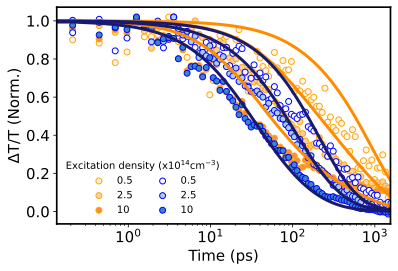

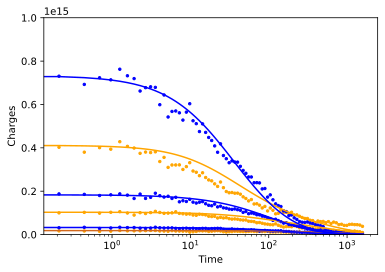

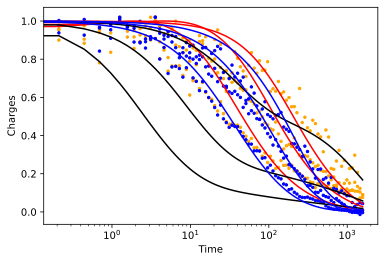

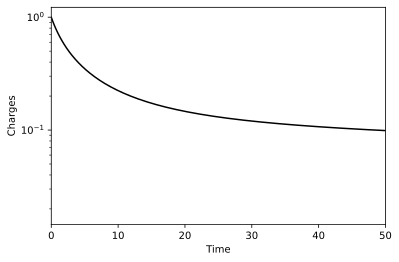

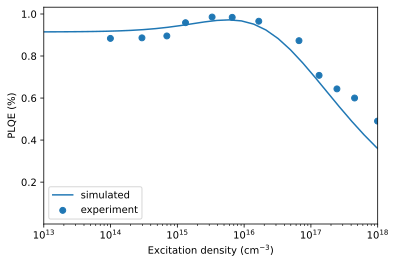

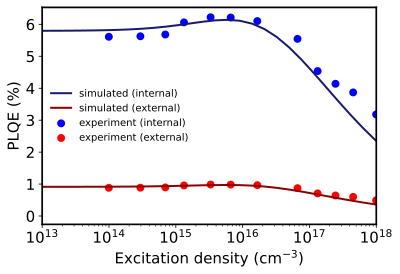

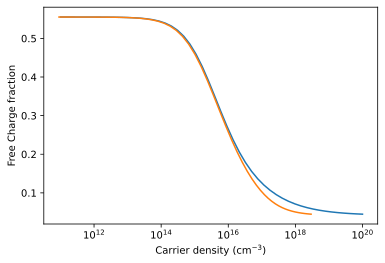

In [16]:

#guess = InteractiveGuess(ode_model, t=t_data1,charges1 = charge_data1, excitons1 = exciton_data1,charges2 = charge_data2, excitons2 = exciton_data2,charges3 = charge_data3, excitons3= exciton_data3, n_points=20)
#guess.execute()
#print(guess)

#fit = Fit(ode_model, t=t_data1,charges1 = charge_data1, excitons1 = exciton_data1,charges2 = charge_data2, excitons2 = exciton_data2,charges3 = charge_data3, excitons3= exciton_data3,absolute_sigma=False)# minimizer=BasinHopping)
#fit_result = fit.execute()
#print(fit_result)
R_init_S = 0.7#R_init_guess
fc_ratio = 0.9
charge_data1 = (nn1*(1-R_init_S)/(1+.5*fc_ratio)+nn1*2*(1-R_init_S)/(1+2/fc_ratio))*charge_1
exciton_data1 = nn1*(R_init_S)*exciton_1
charge_data2 = (nn2*(1-R_init_S)/(1+.5*fc_ratio)+nn2*2*(1-R_init_S)/(1+2/fc_ratio))*charge_2
exciton_data2 = nn2*(R_init_S)*exciton_2
charge_data3 = (nn3*(1-R_init_S)/(1+.5*fc_ratio)+nn3*2*(1-R_init_S)/(1+2/fc_ratio))*charge_3
exciton_data3 = nn3*(R_init_S)*exciton_3

data = [charge_data1,charge_data2,charge_data3,exciton_data1,exciton_data2,exciton_data3]
values = range(len(data))
ode_model = ODEModel(model, initial={t: 0, excitons1:nn1*R_init_S, ct_s1: nn1*(1-R_init_S)/(1+.5*fc_ratio), ct_t1: 0, fc1:nn1*2*(1-R_init_S)/(1+2/fc_ratio), excitons2:nn2*R_init_S, ct_s2: nn2*(1-R_init_S)/(1+.5*fc_ratio), ct_t2: 0, fc2:nn2*2*(1-R_init_S)/(1+2/fc_ratio), excitons3:nn3*R_init_S, ct_s3: nn3*(1-R_init_S)/(1+.5*fc_ratio), ct_t3: 0, fc3:nn3*2*(1-R_init_S)/(1+2/fc_ratio)})


from collections import OrderedDict
init_params = OrderedDict([('a_s_non', 1/295),
             ('a_s_split', 1/1700),
             ('a_s_rad', 1/2900),
             ('b_s', 2e-8*1e-12*1e3),
             ('b_s_fc', 2.6e-8*1e-12*1e3),
             ('a_ct_split',1/600),
             ('a_ct_join', 1/500),
             ('a_ct_non', 1/450),
             ('a_ct_isc', 1/1000),              
             ('b_ct', 2.2e-8*1e-12*1e3),
             ('a_fc_non',1/800),
             ('b_fuse',200e-8*1e-12*1e3)])


model_fit = ode_model(t=t_data1, **init_params)._asdict()




# fig = plt.figure()
# ax = fig.add_subplot(111)
# Reds = cm = plt.get_cmap('Reds') 
# cNorm  = colors.Normalize(vmin=0, vmax=values[3])
# scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=Reds)
# lines = []
# for idx in values[0:3]:
#     colorVal = scalarMap.to_rgba(values[idx])
#             #colorText = (ratios_absorption[idx])
#     retLine = ax.scatter(t_data1, norm_mult*data[idx]/max(data[idx]),
#             facecolors=colorVal, edgecolors = 'r')#,s = 8)
#                        #label=colorText)
#     lines.append(retLine)
# Blues = cm = plt.get_cmap('Blues') 
# cNorm  = colors.Normalize(vmin=3, vmax=values[5])
# scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=Blues)
# lines = []
# for idx in values[3::]:
#     colorVal = scalarMap.to_rgba(values[idx])
#             #colorText = (ratios_absorption[idx])
#     retLine = ax.scatter(t_data1, norm_mult*data[idx]/max(data[idx]),
#             facecolors=colorVal, edgecolors = 'b')#,s = 8)
#                        #label=colorText)
#     lines.append(retLine)
      
colorText = ['0.5','2.5','10']
fig = plt.figure()
ax = fig.add_subplot(111)
ax.tick_params(axis='both', which='major', labelsize=15)
values = range(len(data))
Reds = cm = plt.get_cmap('Oranges') 
cNorm  = colors.Normalize(vmin=0, vmax=values[3]+1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=Reds)
lines = []
for idx in values[0:3]:
    colorVal = scalarMap.to_rgba(values[idx])
            #colorText = (ratios_absorption[idx])
    retLine = ax.scatter(t_data1, norm_mult*data[idx]/max(data[idx]),
            facecolors=colorVal, edgecolors = 'orange',
                       label=colorText[idx])
    lines.append(retLine)
Blues = cm = plt.get_cmap('Blues') 
cNorm  = colors.Normalize(vmin=3, vmax=values[5]+1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=Blues)
lines = []
for idx in values[3::]:
    colorVal = scalarMap.to_rgba(values[idx])
            #colorText = (ratios_absorption[idx])
    retLine = ax.scatter(t_data1, norm_mult*data[idx]/max(data[idx]),
            facecolors=colorVal, edgecolors = 'b',
                       label=colorText[idx-3])
    lines.append(retLine)
        
ax.plot(t_data1, (model_fit[ct_s1]+model_fit[ct_t1]+model_fit[fc1])/max(model_fit[ct_s1]+model_fit[ct_t1]+model_fit[fc1]),color = 'darkorange', linewidth = 3)
ax.plot(t_data1, (model_fit[ct_s2]+model_fit[ct_t2]+model_fit[fc2])/max(model_fit[ct_s2]+model_fit[ct_t2]+model_fit[fc2]),color = 'darkorange', linewidth = 3)
ax.plot(t_data1, (model_fit[ct_s3]+model_fit[ct_t3]+model_fit[fc3])/max(model_fit[ct_s3]+model_fit[ct_t3]+model_fit[fc3]),color = 'darkorange', linewidth = 3)

ax.plot(t_data1, model_fit[excitons1]/max(model_fit[excitons1]),color = 'midnightblue', linewidth = 3)
ax.plot(t_data1, model_fit[excitons2]/max(model_fit[excitons2]),color = 'midnightblue', linewidth = 3)
ax.plot(t_data1, model_fit[excitons3]/max(model_fit[excitons3]),color = 'midnightblue', linewidth = 3)
for i in iter(ax.spines.values()):
    i.set_linewidth(1.7) 
handles,labels = ax.get_legend_handles_labels()
ax.legend(frameon = False, ncol = 2,title="Excitation density (x10$^{14}$cm$^{-3}$)")#loc='lower right'
ax.set_xlabel('Time (ps)',fontsize = 15)
ax.set_ylabel('$\Delta$T/T (Norm.)',fontsize = 15)
ax.set_xscale('log')
ax.set_xlim(0,1550)
fig.savefig('TA_glob_fit_CT.svg',bbox_inches='tight')

#ax.set_ylim(0,1e15)


fig = plt.figure()
ax = fig.add_subplot(111)
values = range(len(data))
for idx in values:
    if (idx<3):
        ax.scatter(t_data1, norm_mult*data[idx],color = 'orange',s = 6)
    else:
        ax.scatter(t_data1, norm_mult*data[idx],color = 'blue',s = 6)
ax.plot(t_data1, (model_fit[ct_s1]+model_fit[ct_t1]+model_fit[fc1]),color = 'chocolate')
ax.plot(t_data1, (model_fit[ct_s2]+model_fit[ct_t2]+model_fit[fc2]),color = 'orange')
ax.plot(t_data1, (model_fit[ct_s3]+model_fit[ct_t3]+model_fit[fc3]),color = 'orange')

ax.plot(t_data1, model_fit[excitons1],color = 'blue')
ax.plot(t_data1, model_fit[excitons2],color = 'blue')
ax.plot(t_data1, model_fit[excitons3],color = 'blue')

ax.set_xlabel('Time')
ax.set_ylabel('Charges')
ax.set_xscale('log')
ax.set_ylim(0,1e15)
#ax.set_xlim(-.1,2)

fig = plt.figure()
ax = fig.add_subplot(111)
values = range(len(data))
for idx in values:
    if (idx<3):
        ax.scatter(t_data1, norm_mult*data[idx]/max(data[idx]),color = 'orange',s = 6)
    else:
        ax.scatter(t_data1, norm_mult*data[idx]/max(data[idx]),color = 'blue',s = 6)
ax.plot(t_data1, (model_fit[ct_s1]/max(model_fit[ct_s1])),color = 'red')
ax.plot(t_data1, (model_fit[ct_s2]/max(model_fit[ct_s2])),color = 'red')
ax.plot(t_data1, (model_fit[ct_s3]/max(model_fit[ct_s3])),color = 'red')
ax.plot(t_data1, (model_fit[fc1]/max(model_fit[fc1])),color = 'black')
ax.plot(t_data1, (model_fit[fc2]/max(model_fit[fc2])),color = 'black')
ax.plot(t_data1, (model_fit[fc3]/max(model_fit[fc3])),color = 'black')

ax.plot(t_data1, model_fit[excitons1]/max(model_fit[excitons1]),color = 'blue')
ax.plot(t_data1, model_fit[excitons2]/max(model_fit[excitons2]),color = 'blue')
ax.plot(t_data1, model_fit[excitons3]/max(model_fit[excitons3]),color = 'blue')

ax.set_xlabel('Time')
ax.set_ylabel('Charges')
ax.set_xscale('log')
#ax.set_ylim(0,1e15)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t_data1, (model_fit[fc3]/max(model_fit[fc3])),color = 'black')
ax.set_xlabel('Time')
ax.set_ylabel('Charges')
ax.set_yscale('log')
ax.set_xlim(0,50)

PLQE_data_init = np.genfromtxt('Y6_PLQE_fluence.csv',delimiter=',')
PLQE_power = PLQE_data_init[:,0]
PLQE_data = (1/3)*PLQE_data_init[:,1]
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.scatter(PLQE_power,PLQE_data)
# ax.set_xscale('log')

wavelength = 530e-9
thickness = 80e-9
k = .8 #from kerremans, Armin et al. 
alpha = 4*np.pi*k/wavelength
OD = -np.log10(np.exp(-alpha*thickness))
absorb = (1-10**(-OD))
reprate = 25000
FWHM = 2e-3
power_steady = PLQE_power*1e-6
nn_data = absorb*power_steady/((h*c/wavelength)*np.pi*(FWHM/2)**2*thickness*reprate)*1e-6


a_s_non = list(init_params.values())[0]*1e12  #.00002e-28
a_s_split = list(init_params.values())[1]*1e12 #0.00002e-28
a_s_rad = list(init_params.values())[2]*1e12  #1/(1030e-12)
b_s = list(init_params.values())[3]*1e9  #1/(510e-12)
b_s_fc = list(init_params.values())[4]*1e9  #1/(1200e-12)
a_ct_split = list(init_params.values())[5] *1e12 #1/(500e-12)
a_ct_join = list(init_params.values())[6]*1e12  #5500e-11
a_ct_non = list(init_params.values())[7]*1e12 #100e-11
a_ct_isc = list(init_params.values())[8]*1e12 #100e-11
b_ct = list(init_params.values())[9]*1e9# 1.7e-8
a_fc_non = list(init_params.values())[10]*1e12
b_fuse = list(init_params.values())[11]*1e9

eta_esc= .15

# R_init_S = 0.7#R_init_guess
# fc_ratio = 0.001
#     D(excitons1,t): -(a_s_non+a_s_split+a_s_rad)*excitons1-b_s*excitons1**2-b_s_fc*excitons1*(fc1+ct_s1+ct_t1)+a_ct_join*ct_s1,
#     D(ct_s1,t):  -(a_ct_non+a_ct_join+a_ct_split)*ct_s1-b_ct*ct_s1**2-b_s_fc*excitons1*ct_s1+.25*b_fuse*fc1**2+a_s_split*excitons1,
#     D(ct_t1,t): -(a_ct_non+a_ct_split)*ct_t1-b_ct*ct_t1**2-b_s_fc*excitons1*ct_t1+.75*b_fuse*fc1**2,
#     D(fc1,t):  -a_fc_non*fc1-b_fuse*fc1**2+2*a_ct_split*(ct_s1+ct_t1),
#         excitons1:nn1*(1-R_init), ct_s1: nn1*(R_init-(.9*R_init)), ct_t1: .05*R_init, fc1:.05*R_init
        
def dP_dt(P,t,G):
    G1 = G[0]
    G2 = G[1]
    G3 = G[2]
    excitons = P[0] 
    ct_s = P[1]
    ct_t = P[2]
    fc = P[3]
    return [-(a_s_non+a_s_split+a_s_rad)*excitons-b_s*excitons**2-b_s_fc*excitons*(fc+ct_s+ct_t)+a_ct_join*ct_s+G1,
            -(a_ct_non+a_ct_join+a_ct_split+a_ct_isc)*ct_s-b_ct*ct_s**2-b_s_fc*excitons*ct_s+.25*b_fuse*fc**2+a_s_split*excitons+a_ct_isc*ct_t+G2,
            -(a_ct_non+a_ct_split+a_ct_isc)*ct_t-b_ct*ct_t**2-b_s_fc*excitons*ct_t+.75*b_fuse*fc**2+a_ct_isc*ct_s,
            -a_fc_non*fc-b_fuse*fc**2+2*a_ct_split*(ct_s+ct_t)+G3]

ts = np.linspace(0, 1e-6, 60)

N_ph = 1e16*np.logspace(1,10,num = 50)*1e-6
#R_init = .3
PLQE_sim = []
charge_ratio = []
carrier_tot= []
for nn in N_ph:
    P0 = [nn*R_init_S,nn*(1-R_init_S)/(1+.5*fc_ratio),0,nn*2*(1-R_init_S)/(1+2/fc_ratio)]
    G = [P0[0]/600e-12,P0[1]/600e-12,P0[3]/600e-12]
    Ps = odeint(dP_dt, P0, ts, args = (G,))
    excitons = Ps[:,0]
    ct_s = Ps[:,1]
    ct_t = Ps[:,2]
    fc = Ps[:,3]
    PLQE_theory_n = ((-a_s_rad*excitons)/(-(a_s_non+a_s_split+a_s_rad)*excitons-b_s*excitons**2-b_s_fc*excitons*(fc+ct_s+ct_t)+a_ct_join*ct_s+-(a_ct_non+a_ct_join+a_ct_split)*ct_s-b_ct*ct_s**2-b_s_fc*excitons*ct_s+.25*b_fuse*fc**2+a_s_split*excitons+-(a_ct_non+a_ct_split)*ct_t-b_ct*ct_t**2-b_s_fc*excitons*ct_t+.75*b_fuse*fc**2+-a_fc_non*fc-b_fuse*fc**2+2*a_ct_split*(ct_s+ct_t)))
    charge_ratio = np.append(charge_ratio,(fc[-1]/(fc[-1]+ct_s[-1]+ct_t[-1]+excitons[-1])))
    carrier_tot = np.append(carrier_tot,(fc[-1]+ct_s[-1]+ct_t[-1]+excitons[-1]))
    PLQE_sim = np.append(PLQE_sim,PLQE_theory_n[-1])
    
PLQE_ext_sim = PLQE_sim*eta_esc/(1-PLQE_sim+PLQE_sim*eta_esc)
PLQE_ext_sim_no_recycle = PLQE_sim*eta_esc

N_solar = 1.266e40 ##photons absorbed per sec
nn = N_solar
P0 = [0,0,0,0]#[nn*R_init_S,nn*(1-R_init_S)/(1+.5*fc_ratio),0,nn*2*(1-R_init_S)/(1+2/fc_ratio)]
G = [P0[0],P0[1],P0[3]]
Ps = odeint(dP_dt, P0, ts, args = (G,))
excitons = Ps[:,0]
ct_s = Ps[:,1]
ct_t = Ps[:,2]
fc = Ps[:,3]
print(fc[-1])


#n = 1e19*np.logspace(1,10)*1e-6

#PLQE_int = (a_rad*excitons+b_rad*charges**2)/((a_non+a_rad)*excitons+b_rad*charges**2+b_non*excitons**2)
PLQE_data_int = PLQE_data*.01/(eta_esc+PLQE_data*.01-eta_esc*PLQE_data*.01)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(N_ph,PLQE_ext_sim*100, label = 'simulated')
ax.scatter(nn_data,PLQE_data,label = 'experiment')
#ax.plot(N_ph,charge_ratio)
ax.set_xlabel('Excitation density (cm$^{-3}$)')
ax.set_ylabel('PLQE (%)')
ax.set_xscale('log')
ax.set_xlim(1e13,1e18)  
#ax.set_yscale('log')
#ax.set_ylim(2e-1,1.1)
#ax.set_xlim(1e14,1e19)
ax.legend()
#fig.savefig('PLQE_with_TA_fit.svg', bbox_inches='tight')


# ax.tick_params(axis='both', which='major', labelsize=15)
# ax.set_xlabel('Excitation density (cm$^{-3}$)',fontsize = 15)
# ax.set_ylabel('PLQE (Normalised)',fontsize = 15)
# ax.set_xscale('log')
# ax.set_xlim(1e13,1e18)  
# for i in iter(ax.spines.values()):
#     i.set_linewidth(1.7) 
# handles,labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels,title="% Free Charge")#loc='lower right'
# #ax.set_yscale('log')
# ax.set_ylim(0e-1,1.05)
# fig.savefig('PLQE_explainer.svg', bbox_inches='tight')


fig = plt.figure()
ax = fig.add_subplot(111)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.plot(N_ph,PLQE_sim*100,color = 'midnightblue',linewidth = 2,label = 'simulated (internal)')
ax.plot(N_ph,PLQE_ext_sim*100,color = 'darkred',linewidth = 2,label = 'simulated (external)')
#ax.plot(carrier_tot, PLQE_sim*100)
#ax.plot(N_ph,PLQE_ext_sim_no_recycle*100,color = 'orange')
ax.scatter(nn_data,PLQE_data_int*100,color = 'blue',linewidth = 2,label = 'experiment (internal)')
ax.scatter(nn_data,PLQE_data,color = 'red',linewidth = 2,label = 'experiment (external)')
for i in iter(ax.spines.values()):
    i.set_linewidth(1.7) 
ax.set_xlabel('Excitation density (cm$^{-3}$)',fontsize = 15)
ax.set_ylabel('PLQE (%)',fontsize = 15)
ax.set_xscale('log')
ax.set_xlim(1e13,1e18)  
ax.legend(frameon = False)
#fig.savefig('PLQE_sim_plus_expt.svg', bbox_inches='tight')


fig = plt.figure()
ax = fig.add_subplot(111)
#ax.plot(nn*1e-6,xx)
ax.plot(N_ph,charge_ratio)
ax.plot(carrier_tot,charge_ratio)
#ax.plot(N_ph,(charge_ratio-0.4)/max(charge_ratio-.4))
ax.set_xlabel('Carrier density (cm$^{-3}$)')
ax.set_ylabel('Free Charge fraction')
ax.legend(frameon = False)
ax.set_xscale('log')

In [90]:
from collections import OrderedDict

n_points = 2
# init_params = OrderedDict([('a_s_non', 1/295),
#              ('a_s_split', 1/1700),
#              ('a_s_rad', 1/2900),
#              ('b_s', 2e-8*1e-12*1e3),
#              ('b_s_fc', 2.6e-8*1e-12*1e3),
#              ('a_ct_split',1/600),
#              ('a_ct_join', 1/500),
#              ('a_ct_non', 1/450),
#              ('a_ct_isc', 1/1000),              
#              ('b_ct', 2.2e-8*1e-12*1e3),
#              ('a_fc_non',1/800),
#              ('b_fuse',200e-8*1e-12*1e3)])
# fc_ratio_m = np.linspace(0.05, 1,n_points)
# a1_s_split_m = np.linspace(1/290, 1/10000, 2)
# b1_s_m = np.linspace(1e-9*1e-12*1e3,3e-7*1e-12*1e3, n_points)
# b1_s_fc_m = np.linspace(1e-9*1e-12*1e3,3e-7*1e-12*1e3, 2)
# a1_ct_split_m = np.linspace(1/290, 1/10000, n_points)
# a1_ct_join_m = np.linspace(1/290, 1/10000, n_points)
# a1_ct_non_m = np.linspace(1/290, 1/10000, n_points)
# b1_ct_m = np.linspace(1e-9*1e-12*1e3,3e-7*1e-12*1e3, n_points)
# a1_fc_non_m = np.linspace(1/290, 1/10000, n_points)
# b1_fuse_m = np.linspace(1e-9*1e-12*1e3,2e-5*1e-12*1e3, 2)

fc_ratio_m = np.linspace(0, 1,4)
a1_s_split_m = np.linspace(1/1000, 1/2500, n_points)
b1_s_m = np.linspace(1e-8*1e-12*1e3,3e-8*1e-12*1e3, n_points)
b1_s_fc_m = np.linspace(1.6e-8*1e-12*1e3,3e-8*1e-12*1e3, n_points)
a1_ct_split_m = np.linspace(1/400, 1/800, n_points)
a1_ct_join_m = np.linspace(1/400, 1/1000, n_points)
a1_ct_non_m = np.linspace(1/400, 1/1000, n_points)
b1_ct_m = np.linspace(1.2e-8*1e-12*1e3,3e-8*1e-12*1e3, n_points)
a1_fc_non_m = np.linspace(1/600, 1/2000, n_points)
b1_fuse_m = np.linspace(100e-8*1e-12*1e3,300e-8*1e-12*1e3, n_points)


ts = np.linspace(0, 1e-6, 15)

N_ph = 1e13*np.logspace(1,3,num = 2)*1e-6 ## desnity in cm3

variance = []
charge_ratio_low = []
charge_ratio_1sun = []


a_s_non1 =Parameter('a_s_non1', value = (1/(395)),min = 0,absolute_sigma = False,fixed = False)#1/(280)
a_s_split1 = Parameter('a_s_split1', value =(1/(1200)),min = 0,absolute_sigma = False,fixed = True)#1/(120e-12)
a_s_rad1 = Parameter('a_s_rad1',value =1/3400,min = 0,fixed = True)#1e6,min = 0,fixed = True)
b_s1 = Parameter('b_s1', value = 0.2e-8*1e-12*1e3,min = 0,absolute_sigma = False,fixed = True)##2.2e-11*1e12
b_s_fc1 = Parameter('b_s_fc1', value = 1e-8*1e-12*1e3,min = 0,absolute_sigma = False,fixed = True)#.495e-11,min = 0,fixed = False)

a_ct_split1 = Parameter('a_ct_split1', value =(1/(1200)),min = 0,absolute_sigma = False,fixed = True)#1/(120e-12)
a_ct_join1 = Parameter('a_ct_join1', value =(1/(1200)),min = 0,absolute_sigma = False,fixed = True)#1/(120e-12)
a_ct_non1= Parameter('a_ct_non1', value =(1/(1200)),min = 0,absolute_sigma = False,fixed = True)#1/(120e-12)
b_ct1 =Parameter('b_ct1', value = 0.2e-8*1e-12*1e3,min = 0,absolute_sigma = False,fixed = True)##2.2e-11*1e12
a_ct_isc1 =Parameter('a_ct_isc1', value = 0.2e-8*1e-12*1e3,min = 0,absolute_sigma = False,fixed = True)##2.2e-11*1e12

a_fc_non1 = Parameter('a_fc_non1',value =1/(1030),min = 0,absolute_sigma = False, fixed =True)
b_fuse1 = Parameter('b_fuse1', value = 0.5e-8*1e-12*1e3,min = 0,absolute_sigma = False, fixed = True)#1.45e-11*1e12

excitons1,ct_s1,ct_t1,fc1,t,excitons2,ct_s2,ct_t2,fc2,excitons3,ct_s3,ct_t3,fc3 = variables('excitons1,ct_s1,ct_t1,fc1,t,excitons2,ct_s2,ct_t2,fc2,excitons3,ct_s3,ct_t3,fc3')


<ipython-input-91-0242618e64dc>:54: RuntimeWarning: divide by zero encountered in double_scalars
  P0 = [nn*R_init_S,nn*(1-R_init_S)/(1+.5*fc_ratio),0,nn*2*(1-R_init_S)/(1+2/fc_ratio)]
<ipython-input-91-0242618e64dc>:69: RuntimeWarning: divide by zero encountered in double_scalars
  charge_data1 = (nn1*(1-R_init_S)/(1+.5*fc_ratio)+nn1*2*(1-R_init_S)/(1+2/fc_ratio))*charge_1
<ipython-input-91-0242618e64dc>:71: RuntimeWarning: divide by zero encountered in double_scalars
  charge_data2 = (nn2*(1-R_init_S)/(1+.5*fc_ratio)+nn2*2*(1-R_init_S)/(1+2/fc_ratio))*charge_2
<ipython-input-91-0242618e64dc>:73: RuntimeWarning: divide by zero encountered in double_scalars
  charge_data3 = (nn3*(1-R_init_S)/(1+.5*fc_ratio)+nn3*2*(1-R_init_S)/(1+2/fc_ratio))*charge_3
<ipython-input-91-0242618e64dc>:97: RuntimeWarning: divide by zero encountered in double_scalars
  ode_model = ODEModel(model, initial={t: 0, excitons1:nn1*R_init_S, ct_s1: nn1*(1-R_init_S)/(1+.5*fc_ratio), ct_t1: 0, fc1:nn1*2*(1-R_init_S)

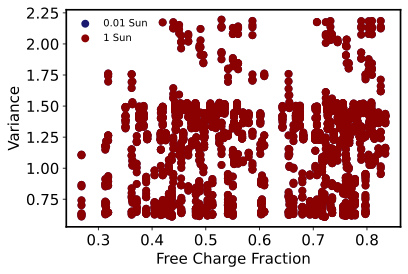

In [91]:

for fc_ratio in fc_ratio_m:
    for a1_s_split in a1_s_split_m:
        for b1_s in b1_s_m:
            for b1_s_fc in b1_s_fc_m:
                for a1_ct_split in a1_ct_split_m:
                    for a1_ct_join in a1_ct_join_m:
                        for a1_ct_non in a1_ct_non_m:
                            for b1_ct in b1_ct_m:
                                for a1_fc_non in a1_fc_non_m:
                                    for b1_fuse in b1_fuse_m:
                                        init_params = OrderedDict([('a_s_non1', 1/295),
                                                     ('a_s_split1', a1_s_split),
                                                     ('a_s_rad1', 1/2900),
                                                     ('b_s1', b1_s),
                                                     ('b_s_fc1', b1_s_fc),
                                                     ('a_ct_split1',a1_ct_split),
                                                     ('a_ct_join1', a1_ct_join),
                                                     ('a_ct_non1', a1_ct_non),
                                                     ('a_ct_isc1', 1/1000),              
                                                     ('b_ct1', b1_ct),
                                                     ('a_fc_non1',a1_fc_non),
                                                     ('b_fuse1',b1_fuse)])
                                        
                                        a_s_non = list(init_params.values())[0]*1e12  #.00002e-28
                                        a_s_split = list(init_params.values())[1]*1e12 #0.00002e-28
                                        a_s_rad = list(init_params.values())[2]*1e12  #1/(1030e-12)
                                        b_s = list(init_params.values())[3]*1e9  #1/(510e-12)
                                        b_s_fc = list(init_params.values())[4]*1e9  #1/(1200e-12)
                                        a_ct_split = list(init_params.values())[5] *1e12 #1/(500e-12)
                                        a_ct_join = list(init_params.values())[6]*1e12  #5500e-11
                                        a_ct_non = list(init_params.values())[7]*1e12 #100e-11
                                        a_ct_isc = list(init_params.values())[8]*1e12 #100e-11
                                        b_ct = list(init_params.values())[9]*1e9# 1.7e-8
                                        a_fc_non = list(init_params.values())[10]*1e12
                                        b_fuse = list(init_params.values())[11]*1e9
                                        
                                        
                                        def dP_dt(P,t,G):
                                            G1 = G[0]
                                            G2 = G[1]
                                            G3 = G[2]
                                            excitons = P[0] 
                                            ct_s = P[1]
                                            ct_t = P[2]
                                            fc = P[3]
                                            return [-(a_s_non+a_s_split+a_s_rad)*excitons-b_s*excitons**2-b_s_fc*excitons*(fc+ct_s+ct_t)+a_ct_join*ct_s+G1,
                                                    -(a_ct_non+a_ct_join+a_ct_split+a_ct_isc)*ct_s-b_ct*ct_s**2-b_s_fc*excitons*ct_s+.25*b_fuse*fc**2+a_s_split*excitons+a_ct_isc*ct_t+G2,
                                                    -(a_ct_non+a_ct_split+a_ct_isc)*ct_t-b_ct*ct_t**2-b_s_fc*excitons*ct_t+.75*b_fuse*fc**2+a_ct_isc*ct_s,
                                                    -a_fc_non*fc-b_fuse*fc**2+2*a_ct_split*(ct_s+ct_t)+G3]
                                        
                                        PLQE_sim = []
                                        charge_ratio = []
                                        for nn in N_ph:
                                            P0 = [nn*R_init_S,nn*(1-R_init_S)/(1+.5*fc_ratio),0,nn*2*(1-R_init_S)/(1+2/fc_ratio)]
                                            G = [P0[0]/600e-12,P0[1]/600e-12,P0[3]/600e-12]
                                            Ps = odeint(dP_dt, P0, ts, args = (G,))
                                            excitons = Ps[:,0]
                                            ct_s = Ps[:,1]
                                            ct_t = Ps[:,2]
                                            fc = Ps[:,3]
                                            PLQE_theory_n = ((-a_s_rad*excitons)/(-(a_s_non+a_s_split+a_s_rad)*excitons-b_s*excitons**2-b_s_fc*excitons*(fc+ct_s+ct_t)+a_ct_join*ct_s+-(a_ct_non+a_ct_join+a_ct_split)*ct_s-b_ct*ct_s**2-b_s_fc*excitons*ct_s+.25*b_fuse*fc**2+a_s_split*excitons+-(a_ct_non+a_ct_split)*ct_t-b_ct*ct_t**2-b_s_fc*excitons*ct_t+.75*b_fuse*fc**2+-a_fc_non*fc-b_fuse*fc**2+2*a_ct_split*(ct_s+ct_t)))
                                            charge_ratio = np.append(charge_ratio,(fc[-1]/(fc[-1]+ct_s[-1]+ct_t[-1]+excitons[-1])))
                                            #carrier_tot = np.append(carrier_tot,(fc[-1]+ct_s[-1]+ct_t[-1]+excitons[-1]))
                                            PLQE_sim = np.append(PLQE_sim,PLQE_theory_n[-1])
                                            
                                        if PLQE_sim[0]<PLQE_sim[1]:#and PLQE_sim[1]*.85< PLQE_sim[0]<PLQE_sim[1]*.95
                                            charge_ratio_low = np.append(charge_ratio_low, charge_ratio[0])
                                            charge_ratio_1sun = np.append(charge_ratio_1sun,charge_ratio[1])
                                            charge_data1 = (nn1*(1-R_init_S)/(1+.5*fc_ratio)+nn1*2*(1-R_init_S)/(1+2/fc_ratio))*charge_1
                                            exciton_data1 = nn1*(R_init_S)*exciton_1
                                            charge_data2 = (nn2*(1-R_init_S)/(1+.5*fc_ratio)+nn2*2*(1-R_init_S)/(1+2/fc_ratio))*charge_2
                                            exciton_data2 = nn2*(R_init_S)*exciton_2
                                            charge_data3 = (nn3*(1-R_init_S)/(1+.5*fc_ratio)+nn3*2*(1-R_init_S)/(1+2/fc_ratio))*charge_3
                                            exciton_data3 = nn3*(R_init_S)*exciton_3

                                            data = [charge_data1,charge_data2,charge_data3,exciton_data1,exciton_data2,exciton_data3]
                                            values = range(len(data))
                                            #a_c,b_fuse,C_c, b_ex_c,a_ex,a_split,b_ex,C_ex = parameters('a_c,b_fuse,C_c, b_ex_c,a_ex,a_split,b_ex,C_ex')


                                            model = {
                                                D(excitons1,t): -(a_s_non1+a_s_split1+a_s_rad1)*excitons1-b_s1*excitons1**2-b_s_fc1*excitons1*(fc1+ct_s1+ct_t1)+a_ct_join1*ct_s1,
                                                D(ct_s1,t):  -(a_ct_non1+a_ct_join1+a_ct_split1+a_ct_isc1)*ct_s1-b_ct1*ct_s1**2-b_s_fc1*excitons1*ct_s1+.25*b_fuse1*fc1**2+a_s_split1*excitons1+a_ct_isc1*ct_t1,
                                                D(ct_t1,t): -(a_ct_non1+a_ct_split1+a_ct_isc1)*ct_t1-b_ct1*ct_t1**2-b_s_fc1*excitons1*ct_t1+.75*b_fuse1*fc1**2+a_ct_isc1*ct_s1,
                                                D(fc1,t):  -a_fc_non1*fc1-b_fuse1*fc1**2+2*a_ct_split1*(ct_s1+ct_t1),
                                                D(excitons2,t): -(a_s_non1+a_s_split1+a_s_rad1)*excitons2-b_s1*excitons2**2-b_s_fc1*excitons2*(fc2+ct_s2+ct_t2)+a_ct_join1*ct_s2,
                                                D(ct_s2,t):  -(a_ct_non1+a_ct_join1+a_ct_split1+a_ct_isc1)*ct_s2-b_ct1*ct_s2**2-b_s_fc1*excitons2*ct_s2+.25*b_fuse1*fc2**2+a_s_split1*excitons2+a_ct_isc1*ct_t2,
                                                D(ct_t2,t): -(a_ct_non1+a_ct_split1+a_ct_isc1)*ct_t2-b_ct1*ct_t2**2-b_s_fc1*excitons2*ct_t2+.75*b_fuse1*fc2**2+a_ct_isc1*ct_s2,
                                                D(fc2,t):  -a_fc_non1*fc2-b_fuse1*fc2**2+2*a_ct_split1*(ct_s2+ct_t2),
                                                D(excitons3,t): -(a_s_non1+a_s_split1+a_s_rad1)*excitons3-b_s1*excitons3**2-b_s_fc1*excitons3*(fc3+ct_s3+ct_t3)+a_ct_join1*ct_s3,
                                                D(ct_s3,t):  -(a_ct_non1+a_ct_join1+a_ct_split1+a_ct_isc1)*ct_s3-b_ct1*ct_s3**2-b_s_fc1*excitons3*ct_s3+.25*b_fuse1*fc3**2+a_s_split1*excitons3+a_ct_isc1*ct_t3,
                                                D(ct_t3,t): -(a_ct_non1+a_ct_split1+a_ct_isc1)*ct_t3-b_ct1*ct_t3**2-b_s_fc1*excitons3*ct_t3+.75*b_fuse*fc3**2+a_ct_isc*ct_s3,
                                                D(fc3,t):  -a_fc_non1*fc3-b_fuse1*fc3**2+2*a_ct_split1*(ct_s3+ct_t3),
                                            }


                                            ode_model = ODEModel(model, initial={t: 0, excitons1:nn1*R_init_S, ct_s1: nn1*(1-R_init_S)/(1+.5*fc_ratio), ct_t1: 0, fc1:nn1*2*(1-R_init_S)/(1+2/fc_ratio), excitons2:nn2*R_init_S, ct_s2: nn2*(1-R_init_S)/(1+.5*fc_ratio), ct_t2: 0, fc2:nn2*2*(1-R_init_S)/(1+2/fc_ratio), excitons3:nn3*R_init_S, ct_s3: nn3*(1-R_init_S)/(1+.5*fc_ratio), ct_t3: 0, fc3:nn3*2*(1-R_init_S)/(1+2/fc_ratio)})
                                            init_params = OrderedDict([('a_s_non1', 1/295),
                                                         ('a_s_split1', a1_s_split),
                                                         ('a_s_rad1', 1/2900),
                                                         ('b_s1', b1_s),
                                                         ('b_s_fc1', b1_s_fc),
                                                         ('a_ct_split1',a1_ct_split),
                                                         ('a_ct_join1', a1_ct_join),
                                                         ('a_ct_non1', a1_ct_non),
                                                         ('a_ct_isc1', 1/1000),              
                                                         ('b_ct1', b1_ct),
                                                         ('a_fc_non1',a1_fc_non),
                                                         ('b_fuse1',b1_fuse)])
                                            
                                            model_fit = ode_model(t=t_data1, **init_params)._asdict()
                                            
                                            ex1_dat =  norm_mult*data[0]/max(data[0])
                                            ex2_dat =  norm_mult*data[1]/max(data[1])
                                            ex3_dat =  norm_mult*data[2]/max(data[2])
                                            
                                            ex1_mod = model_fit[excitons1]/max(model_fit[excitons1])
                                            ex2_mod = model_fit[excitons2]/max(model_fit[excitons2])
                                            ex3_mod = model_fit[excitons3]/max(model_fit[excitons3])
                                            
                                            ch1_dat = norm_mult*data[3]/max(data[3])
                                            ch2_dat = norm_mult*data[4]/max(data[4])
                                            ch3_dat = norm_mult*data[5]/max(data[5])
                                            
                                            ch1_mod = (model_fit[ct_s1]+model_fit[ct_t1]+model_fit[fc1])/max(model_fit[ct_s1]+model_fit[ct_t1]+model_fit[fc1])
                                            ch2_mod = (model_fit[ct_s2]+model_fit[ct_t2]+model_fit[fc2])/max(model_fit[ct_s2]+model_fit[ct_t2]+model_fit[fc2])
                                            ch3_mod = (model_fit[ct_s3]+model_fit[ct_t3]+model_fit[fc3])/max(model_fit[ct_s3]+model_fit[ct_t3]+model_fit[fc3])

                        
                                            variance_n = np.sum(((ex1_dat-ex1_mod)**2+(ex2_dat-ex2_mod)**2+(ex3_dat-ex3_mod)**2+(ch1_dat-ch1_mod)**2+(ch2_dat-ch2_mod)**2+(ch3_dat-ch3_mod)**2)/len(t_data1))
                                            variance = np.append(variance,variance_n)

                                            
                            
fig = plt.figure()
ax = fig.add_subplot(111)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.scatter(charge_ratio_low,variance,color = 'midnightblue',linewidth = 2,label = '0.01 Sun')
ax.scatter(charge_ratio_1sun,variance,color = 'darkred',linewidth = 2,label = '1 Sun')

for i in iter(ax.spines.values()):
    i.set_linewidth(1.7) 
ax.set_xlabel('Free Charge Fraction',fontsize = 15)
ax.set_ylabel('Variance',fontsize = 15)
#ax.set_xscale('log')
#ax.set_xlim(1e13,1e18)  
ax.legend(frameon = False)              
            
    


In [75]:
variance

array([2.13379193, 2.12668022, 2.18717712, 2.1797334 , 2.12912796,
       2.12696475, 2.208324  ])

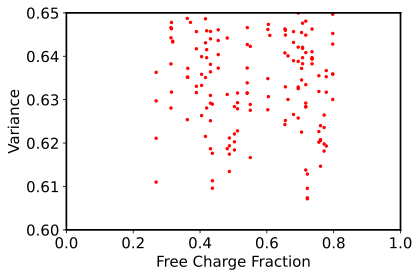

In [103]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.tick_params(axis='both', which='major', labelsize=15)
#ax.scatter(charge_ratio_low,variance,color = 'b',s = 3,label = '0.01 Sun')
ax.scatter(charge_ratio_1sun,variance,color = 'r',s = 6,label = '1 Sun')

for i in iter(ax.spines.values()):
    i.set_linewidth(1.7) 
ax.set_xlabel('Free Charge Fraction',fontsize = 15)
ax.set_ylabel('Variance',fontsize = 15)
#ax.set_xscale('log')
ax.set_ylim(0.6,0.65)
ax.set_xlim(0,1)
#ax.legend(frameon = False)
fig.savefig('varianceCT_round_2_short.svg', bbox_inches='tight')


In [82]:
import win32clipboard as clipboard

def toClipboardForExcel(array):
    """
    Copies an array into a string format acceptable by Excel.
    Columns separated by \t, rows separated by \n
    """
    # Create string from array
    line_strings = []
    for line in array:
        line_strings.append("\t".join(line.astype(str)).replace("\n",""))
    array_string = "\r\n".join(line_strings)

    # Put string into clipboard (open, clear, set, close)
    clipboard.OpenClipboard()
    clipboard.EmptyClipboard()
    clipboard.SetClipboardText(array_string)
    clipboard.CloseClipboard()

In [99]:
np.savetxt('variance2.csv',variance,delimiter = ",")
np.savetxt('charge_ratio_low2.csv',charge_ratio_low,delimiter = ",")
np.savetxt('charge_ratio_1sun2.csv',charge_ratio_1sun,delimiter = ",")